In [ ]:
import os,cv2,time,warnings,keras
import numpy as np
from google.colab.patches import cv2_imshow 
from google.colab import drive
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#decorator function for calculating the time 
def calc_time(func):
    def inner(*args, **kwargs):
        st=time.time()
        result=func(*args,**kwargs)
        end= time.time()-st
        print("Total time required: {:.3f} ms".format(end * 1000))
        return result
    return inner

In [ ]:
#function to check if downloaded matches the length given at the website
@calc_time
def check():
  mask=sorted(os.listdir('/content/drive/MyDrive/ComputerVisionProject/finaldata/mask'))
  total=0
  for i in mask:
    dir=len(os.listdir('/content/drive/MyDrive/ComputerVisionProject/finaldata/mask/{}/'.format(i)))
    print("Mask dataset")
    print("lenght of directory {} is {}".format(i,dir))
    total+=dir
  print("total length mask {}".format(total))
  
  nmask=sorted(os.listdir('/content/drive/MyDrive/ComputerVisionProject/finaldata/nomask'))
  total=0
  for i in nmask:
    dir=len(os.listdir('/content/drive/MyDrive/ComputerVisionProject/finaldata/nomask/{}/'.format(i)))
    print("No mask dataset")
    print("lenght of directory {} is {}".format(i,dir))
    total+=dir
  print("total length no mask {}".format(total))

check()

Mask dataset
lenght of directory 00000 is 950
Mask dataset
lenght of directory 01000 is 962
Mask dataset
lenght of directory with_mask is 2165
total length mask 4077
No mask dataset
lenght of directory 00000 is 928
No mask dataset
lenght of directory 01000 is 955
No mask dataset
lenght of directory without_mask is 1930
total length no mask 3813
Total time required: 70011.156 ms


In [ ]:
#data preprocessing
#function to load the train data's images name and their labels
def loadData(path):
  data = []
  labels = []
  for folder in os.listdir(path):
    for sub in os.listdir(path + folder):
      for img in os.listdir(path + folder + "/" + sub):
        data.append((path + folder + "/" + sub + "/" + img))
        labels.append(folder)
  return np.array(data), np.array(labels)

#data is splitted into X and Y
def splitXY(inputs):
  X = []
  Y = []
  for i in range(inputs.shape[0]):
    X.append(inputs[i][0])
    Y.append(inputs[i][1])
  return np.array(X), np.array(Y)

#images are resized and stored into numpy array
def resizeImages(images):
  X = np.ndarray((images.shape[0], 224*224*3), dtype=np.uint8)
  cr_img = []

  for i, img in enumerate(images):
    imgRead = cv2.imread(img, cv2.IMREAD_COLOR)
    try:
      X[i, :] = (cv2.resize(imgRead, (224, 224), interpolation=cv2.INTER_CUBIC)).reshape(224*224*3)       
    except:
      cr_img.append(i)
      #print(i,"  ",img)
      #print(cr_img)
    
    if i%100 == 0:
      print("Processed Images = {}".format(i))
    if i == (images.shape[0]-1):
      print("Processed Images = {}".format(i+1))
  return X, cr_img

In [ ]:
# Function loads the data set and calls the function to preprocess data
# Finally the function generates preprocessed data and stores in a numpy file
# These numpy files contains features and labels which will be used for training and testing our model
@calc_time
def preprocessing():
  print("Processing of Dataset")
  print("---------------------------")

  path = "/content/drive/MyDrive/ComputerVisionProject/finaldata/"
  data, labels = loadData(path)
  
  # Just for verification
  mask_count = len(np.where(labels=="mask")[0])
  no_mask_count = len(np.where(labels=="nomask")[0])
  print("total mask count {}".format(mask_count))
  print("total no mask count {}".format(no_mask_count))
  print("Length of total data {}".format(len(data)))
  print("Total Data = {}".format(data.shape))
  
  print("\nResizing of Images:")
  resizedData, corruptList = resizeImages(data)
  print("\nShape of Data = {}".format(resizedData.shape))
  print("Shape of Labels = {}".format(labels.shape))

  X = np.delete(resizedData, corruptList, 0)
  Y = np.delete(labels, corruptList, 0)
  print(X.shape, Y.shape)

  np.save('/content/drive/MyDrive/ComputerVisionProject/data2_224.npy', X)
  np.save('/content/drive/MyDrive/ComputerVisionProject/labels2_224.npy', Y)

preprocessing()

Processing of Dataset
---------------------------
total mask count 4077
total no mask count 3813
Length of total data 7890
Total Data = (7890,)

Resizing of Images:
Processed Images = 0
Processed Images = 100
Processed Images = 200
Processed Images = 300
Processed Images = 400
Processed Images = 500
Processed Images = 600
Processed Images = 700
Processed Images = 800
Processed Images = 900
Processed Images = 1000
Processed Images = 1100
Processed Images = 1200
Processed Images = 1300
Processed Images = 1400
Processed Images = 1500
Processed Images = 1600
Processed Images = 1700
Processed Images = 1800
Processed Images = 1900
Processed Images = 2000
Processed Images = 2100
Processed Images = 2200
Processed Images = 2300
Processed Images = 2400
Processed Images = 2500
Processed Images = 2600
Processed Images = 2700
Processed Images = 2800
Processed Images = 2900
Processed Images = 3000
Processed Images = 3100
Processed Images = 3200
Processed Images = 3300
Processed Images = 3400
Process

In [ ]:
#function to plot Loss and accuracy curves on training set
def plotgraph(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'firebrick',linewidth=3.0)
  plt.plot(history.history['accuracy'],'turquoise',linewidth=3.0)
  plt.legend(['Training loss','Training Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss and Accuracy',fontsize=16)
  plt.title('Loss Curves and Accuracy Curves',fontsize=16)

In [ ]:
#function to get train and test by reading features and labels stored in numpy file
@calc_time
def get_train_test_set():
  # Loading data
  data = np.load('/content/drive/MyDrive/ComputerVisionProject/data2_224.npy')
  labels = np.load('/content/drive/MyDrive/ComputerVisionProject/labels2_224.npy')

  # One hot encode labels
  unique, inverse = np.unique(labels, return_inverse=True)
  labels = np.eye(unique.shape[0])[inverse]

  # Reshape image array
  data = np.reshape(data,(len(data),224,224,3))

  print("Data   : ",data.shape)
  print("Labels : ",labels.shape)

  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)

  print("Training Data   : ",X_train.shape)
  print("Training Labels : ",y_train.shape)
  print("Testing  Data   : ",X_test.shape)
  print("Testing  Labels : ",y_test.shape)

  return X_train, X_test, y_train, y_test


In [ ]:
#fucntion to build the model and train on the training data
def detection_model(X_train, X_test, y_train, y_test):
  resnet_model = ResNet50(weights='imagenet',include_top=False)

  # Pooling/ flat
  pooling = keras.layers.GlobalAveragePooling2D()(resnet_model.output)

  # Adding fully connected layer 1
  pred = keras.layers.Dense(2, activation='softmax', name="pred")(pooling)

  # Final model
  model = keras.models.Model(inputs = resnet_model.input, outputs=pred)

  # Options setting
  options = keras.optimizers.SGD(learning_rate=1e-3,decay=1e-6,momentum=0.9)

  model.compile(optimizer=options, metrics=["accuracy"],loss='categorical_crossentropy')
  model.summary()
  # saving the best model 
  filepath="/content/drive/MyDrive/ComputerVisionProject/mask-detection.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  # train the model
  start = time.time()
  history = model.fit(X_train, y_train, batch_size = 64, epochs = 5, shuffle=True, callbacks = callbacks_list, validation_data=(X_test, y_test))
  end = time.time()
  #plot loss and accuracy curves
  plotgraph(history)

  # testing the model
  start2 = time.time()
  _,train_acc = model.evaluate(X_train,y_train, batch_size=1)
  _,test_acc = model.evaluate(X_test,y_test, batch_size=1)
  end2 = time.time()

  print("======================================================================================================================================")
  print("Training time : ",end-start)
  print("Testing time  : ",end2-start2)
  print("Training Accuracy : ",train_acc*100)
  print("Testing  Accuracy : ",test_acc*100)
  print("======================================================================================================================================")

In [ ]:
#function is used to evaluate the performance of the model
#once the best model giving highest accuracy is saved 
#the best model is loaded and test to evaluate its performance
@calc_time
def evaluate_best_model(X_train, X_test, y_train, y_test):
  #load the model
  model=load_model("/content/drive/MyDrive/ComputerVisionProject/mask-detection.hdf5")
  #evaluate performance on train and test set
  _,train_acc = model.evaluate(X_train,y_train, batch_size=1)
  _,test_acc = model.evaluate(X_test,y_test, batch_size=1)
  #predict the outcome of the model
  y_pred = model.predict(X_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  print("*****************************")
  print("\nTraining Accuracy is {}".format(train_acc))
  print("\nTesting Accuracy is {}".format(test_acc))
  #View the classification report for test data and predictions
  print("\nClassification report for Mask Detection")
  print(classification_report(y_test, y_pred))
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Mask Detection")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")

Data   :  (7890, 224, 224, 3)
Labels :  (7890, 2)
Training Data   :  (5523, 224, 224, 3)
Training Labels :  (5523, 2)
Testing  Data   :  (2367, 224, 224, 3)
Testing  Labels :  (2367, 2)
Total time required: 5263.915 ms
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
_______________________________________________________________________

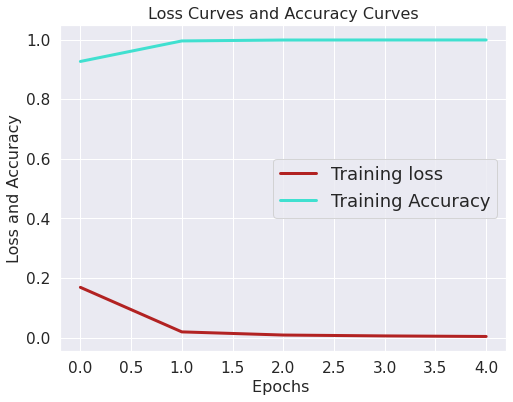

In [ ]:
#function to run above given functions in a sequence
@calc_time
def main():
  #load the dataset
  X_train, X_test, y_train, y_test=get_train_test_set()
  #train the model
  detection_model(X_train, X_test, y_train, y_test)
  #evaluate the performance of the model
  evaluate_best_model(X_train, X_test, y_train, y_test)

if __name__:main()